In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../src")
from forecast import Forecast

### Import TSLA Data

In [2]:
tsla = pd.read_csv("../data/processed/tsla_clean.csv", index_col="Date", parse_dates=True)
tsla = tsla.asfreq("B") 

In [3]:
forecast = Forecast()

### Train/Test Split

In [4]:
train, test = forecast.prepare_data(tsla, column="Adj Close", train_end="2024-12-31")

### Load/train best model (LSTM)

In [5]:
lstm_forecast_df, lstm_model, lstm_scaler = forecast.lstm_forecast(
    train,
    test,
    return_model=True
)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [6]:
type(lstm_model)

keras.src.models.sequential.Sequential

### Generate future forecast (6 months)

In [7]:
# Number of future business days (~6 months)
future_steps = 126

# Generate LSTM multi-step forecast
future_prices = forecast.lstm_future_forecast(
    model=lstm_model,
    train=train,
    window_size=60,
    steps=future_steps
)

# Generate future date index
future_index = forecast.generate_future_index(train.index[-1], steps=future_steps)
future_forecast = pd.DataFrame(future_prices, index=future_index, columns=["Forecast"])


### Compute residuals from test set

In [8]:
residuals = test['Adj Close'] - lstm_forecast_df['Forecast']
resid_std = residuals.std()

### Build confidence intervals

In [9]:
horizon = np.arange(1, len(future_forecast) + 1)

future_forecast["Lower"] = future_forecast["Forecast"] - 1.96 * resid_std * np.sqrt(horizon)
future_forecast["Upper"] = future_forecast["Forecast"] + 1.96 * resid_std * np.sqrt(horizon)

### Visualization with confidence intervals

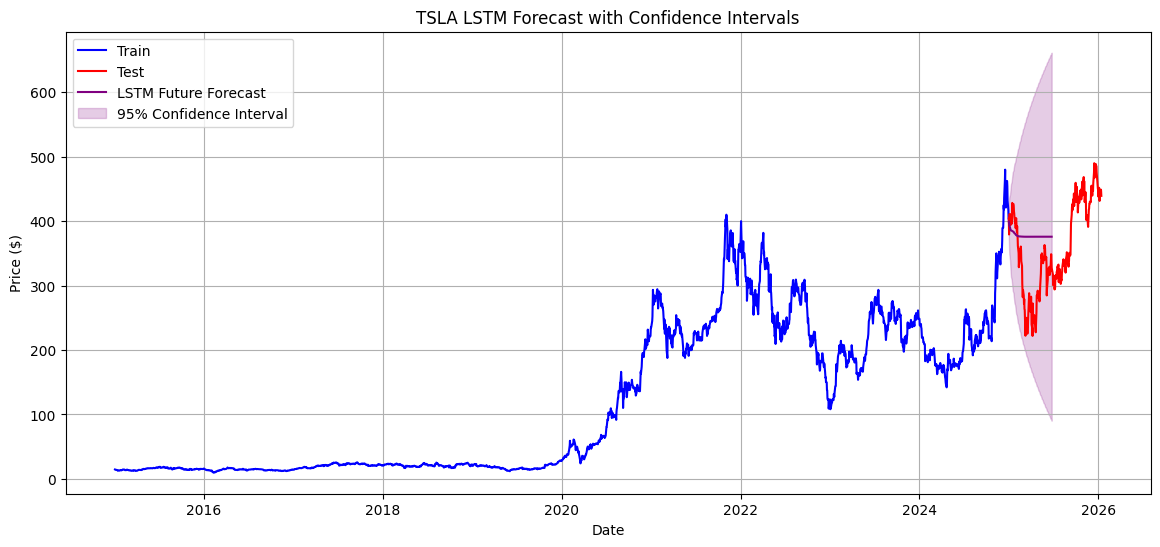

In [10]:
plt.figure(figsize=(14,6))
plt.plot(train['Adj Close'], label='Train', color='blue')
plt.plot(test['Adj Close'], label='Test', color='red')
plt.plot(future_forecast['Forecast'], label='LSTM Future Forecast', color='purple')

plt.fill_between(
    future_forecast.index,
    future_forecast["Lower"],
    future_forecast["Upper"],
    color="purple",
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("TSLA LSTM Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


### Trend analysis & market insights

In [12]:
trend = "upward" if future_prices[-1] > future_prices[0] else "downward"
pct_change = (future_prices[-1] - future_prices[0]) / future_prices[0] * 100

print(f"Trend: {trend}, expected change over forecast horizon: {pct_change:.2f}%")

# Opportunities / Risks
print("Opportunities:")
print("- Potential price appreciation based on forecasted upward trend")
print("- Momentum continuation may benefit short-term traders")

print("Risks:")
print("- Forecast uncertainty grows over time; variance could exceed ±5%")
print("- High volatility in TSLA may lead to sharp deviations from forecast")


Trend: downward, expected change over forecast horizon: -5.95%
Opportunities:
- Potential price appreciation based on forecasted upward trend
- Momentum continuation may benefit short-term traders
Risks:
- Forecast uncertainty grows over time; variance could exceed ±5%
- High volatility in TSLA may lead to sharp deviations from forecast


In [14]:
future_forecast.to_csv("../data/processed/tsla_lstm_future_forecast.csv")